Deep_Learning_Studynotes_(20190713)

study program : https://www.fastcampus.co.kr/data_camp_deeplearning

실습환경 : Google colab gpu 엔진

### step 1) Importing Libraries

In [0]:
!pip install --upgrade tensorflow

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


### step 2) Enable Eager Mode 설정

In [0]:
if tf.__version__ < '2.0.0':
    tf.enable_eager_execution()

### step 3) Hyper Parameters 셋팅

In [0]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100
n_class = 10

### step 4) MNIST/Fashion MNIST Data 선택

In [0]:
# ## MNIST Dataset #########################################################
# mnist = keras.datasets.mnist
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# ##########################################################################

# Fashion MNIST Dataset #################################################
mnist = keras.datasets.fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#########################################################################

### step 5) Datasets 임포트

In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

4423680/4422102 [==============================] - 0s 0us/step


### step 6) 데이터 셋팅

In [0]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

### step 7) Model 설계

In [0]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    ## 기존에 이미지가 28 X 28 사이즈이므로 
    ## 백터로 일자로 펴서 데이터를 넣어줘야 하기 때문에 위와 같이 코딩함
    model.add(keras.layers.Dense(256,activation='relu'))
    ## fully connected layer(MLP 하나의 층)를 추가하는데 몇개의 퍼셉트론을 둘거냐
    ## 여기서는 256개를 두겠다. 활성화함수는 렐루를 쓰겠다.
    model.add(keras.layers.Dense(128,activation='relu'))
    ## 거기에 하나의 층으로 또 128개의 퍼셉트론을 더 쌓겠다. 역시 AF는 렐루로
    model.add(keras.layers.Dense(10,activation='softmax'))
    ## MLP의 마지막 층은 10개로 두겠다. 이 10개는 소프트맥스로..
    return model

In [0]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


### step 8) Loss Function 계산함수 구현

In [0]:
## 아래와 같이 @tf.function을 붙여주면 그래프 모드로 전환되어 연산이 빨라진다.
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss

### step 9) Calculating Gradient & Updating Weights 함수 구현

In [0]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

### step 10) Caculating Model's Accuracy 계산함수 구현

In [0]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

### step 11) Optimizer 설정

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

### step 12) Training 수행

In [0]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
    ## for images, labels in train_dataset.repeat(training_epochs):
    ## 위와 같이 .repeat를 적용해주면 한 에포크를 돌때마다 셔플을 해준다.
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 
          'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.47122025 train accuracy =  0.8334 test accuracy =  0.8503
Epoch: 2 loss = 0.34015965 train accuracy =  0.8769 test accuracy =  0.8601
Epoch: 3 loss = 0.30349249 train accuracy =  0.8895 test accuracy =  0.8727
Epoch: 4 loss = 0.28034952 train accuracy =  0.8972 test accuracy =  0.8774
Epoch: 5 loss = 0.25995550 train accuracy =  0.9037 test accuracy =  0.8777
Epoch: 6 loss = 0.24598221 train accuracy =  0.9084 test accuracy =  0.8732
Epoch: 7 loss = 0.23506032 train accuracy =  0.9131 test accuracy =  0.8802
Epoch: 8 loss = 0.22246923 train accuracy =  0.9170 test accuracy =  0.8859
Epoch: 9 loss = 0.21404687 train accuracy =  0.9201 test accuracy =  0.8873
Epoch: 10 loss = 0.20306093 train accuracy =  0.9240 test accuracy =  0.8851
Epoch: 11 loss = 0.19534108 train accuracy =  0.9262 test accuracy =  0.8868
Epoch: 12 loss = 0.18795916 train accuracy =  0.9305 test accuracy =  0.8850
Epoch: 13 loss = 0.18208914 train accuracy =  0.

### step 13) 트레이닝한 모델 테스트

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

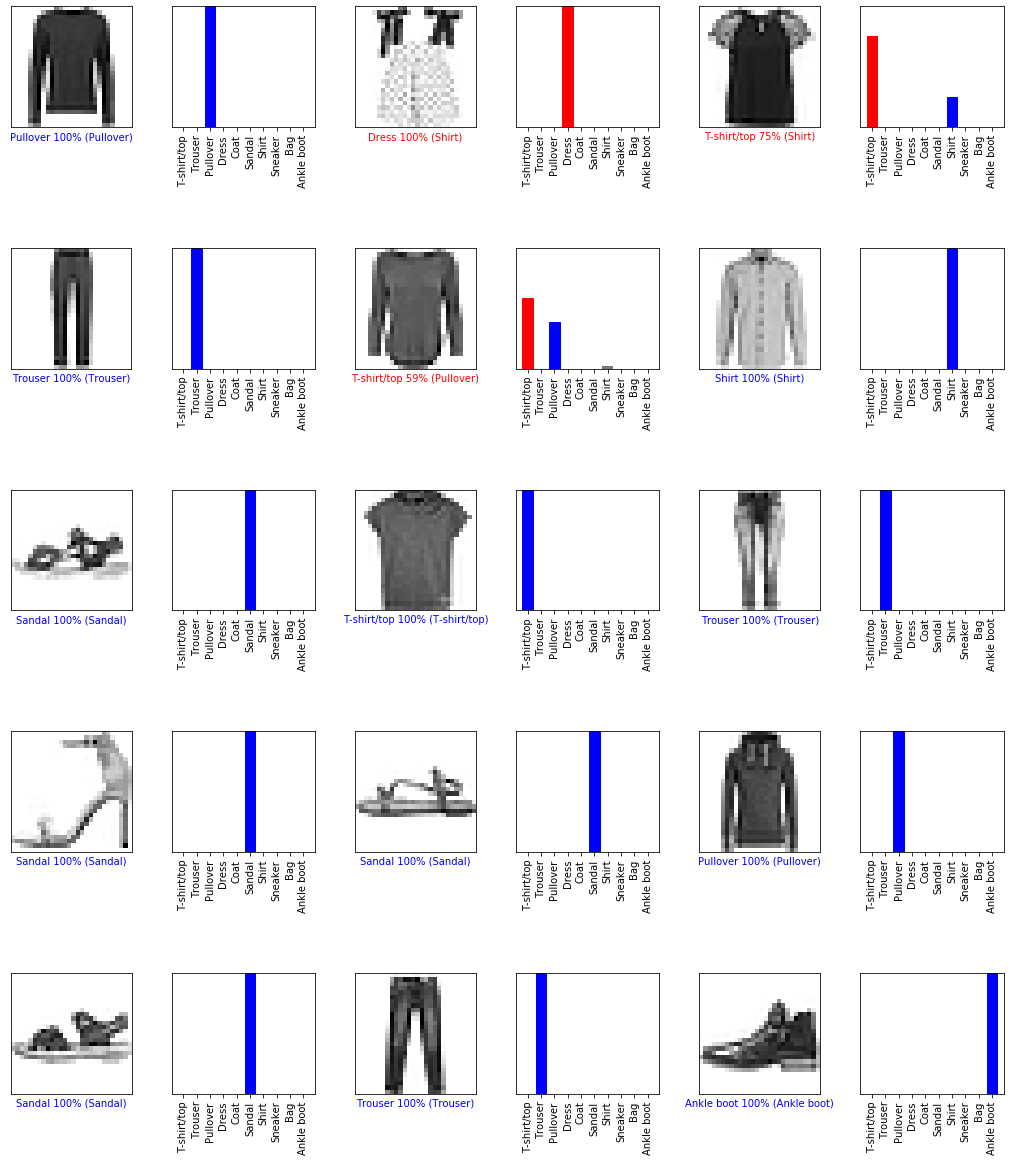

In [0]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

#### step 14) step 7) 모델 설계 부분에서 레이어를 더 쌓아서 모델을 만들고 테스트를 해보자

In [0]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))    
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss

In [0]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [0]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
    ## for images, labels in train_dataset.repeat(training_epochs):
    ## 위와 같이 .repeat를 적용해주면 한 에포크를 돌때마다 셔플을 해준다.
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 
          'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.47201630 train accuracy =  0.8306 test accuracy =  0.8460
Epoch: 2 loss = 0.33868349 train accuracy =  0.8758 test accuracy =  0.8626
Epoch: 3 loss = 0.30029640 train accuracy =  0.8892 test accuracy =  0.8626
Epoch: 4 loss = 0.27897891 train accuracy =  0.8963 test accuracy =  0.8759
Epoch: 5 loss = 0.26005241 train accuracy =  0.9031 test accuracy =  0.8824
Epoch: 6 loss = 0.24540581 train accuracy =  0.9083 test accuracy =  0.8710
Epoch: 7 loss = 0.23372877 train accuracy =  0.9128 test accuracy =  0.8733
Epoch: 8 loss = 0.22330683 train accuracy =  0.9165 test accuracy =  0.8792
Epoch: 9 loss = 0.21107051 train accuracy =  0.9198 test accuracy =  0.8870
Epoch: 10 loss = 0.20567133 train accuracy =  0.9222 test accuracy =  0.8879
Epoch: 11 loss = 0.19724540 train accuracy =  0.9249 test accuracy =  0.8895
Epoch: 12 loss = 0.18724051 train accuracy =  0.9298 test accuracy =  0.8878
Epoch: 13 loss = 0.17988257 train accuracy =  0.

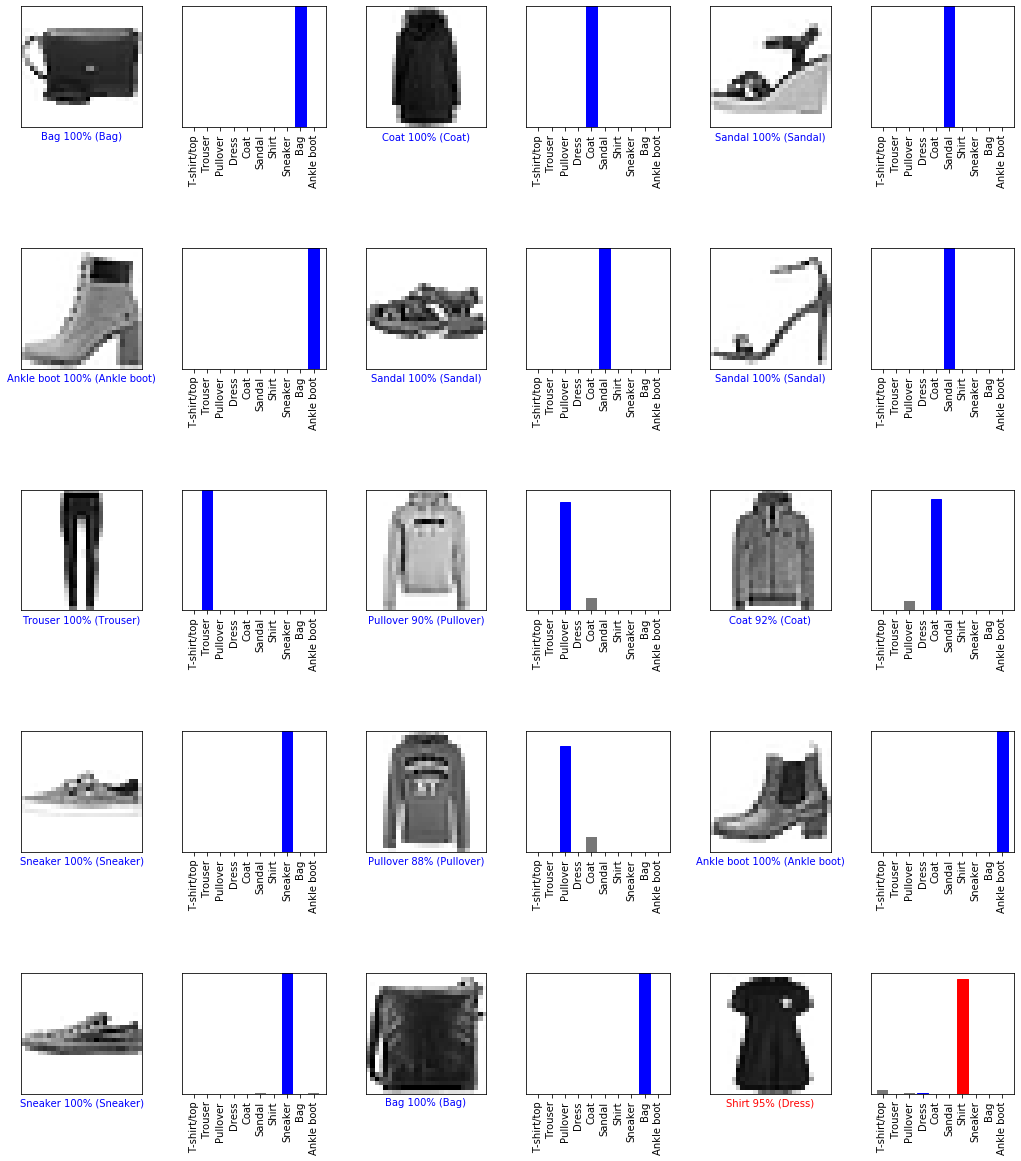

In [0]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

위의 결과에서 알 수 있듯이 레이어를 더 쌓아도 기존의 모델과 별 차이가 없음을 확인할 수 있었다.

그렇다면 레이어를 더 쌓았는데 비슷하거나 좀 더 성능이 안좋게 나온거라면 오버피팅이 아니냐라는 판단을 할 수 있고, drop-out을 적용해보자.

### step 15) 위에 모델에서 추가적으로 drop-out을 적용한 MLP 모델 만들기

In [0]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100
n_class = 10
drop_rate = 0.3

def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [0]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [0]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss  

In [0]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [0]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 
          'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.68396634 train accuracy =  0.7945 test accuracy =  0.8314
Epoch: 2 loss = 0.45805994 train accuracy =  0.8591 test accuracy =  0.8566
Epoch: 3 loss = 0.42066765 train accuracy =  0.8699 test accuracy =  0.8560
Epoch: 4 loss = 0.39140019 train accuracy =  0.8771 test accuracy =  0.8569
Epoch: 5 loss = 0.37540531 train accuracy =  0.8844 test accuracy =  0.8679
Epoch: 6 loss = 0.36260232 train accuracy =  0.8876 test accuracy =  0.8688
Epoch: 7 loss = 0.35164994 train accuracy =  0.8912 test accuracy =  0.8550
Epoch: 8 loss = 0.33950019 train accuracy =  0.8947 test accuracy =  0.8650
Epoch: 9 loss = 0.33450663 train accuracy =  0.8967 test accuracy =  0.8739
Epoch: 10 loss = 0.32979870 train accuracy =  0.8985 test accuracy =  0.8757
Epoch: 11 loss = 0.32060406 train accuracy =  0.9019 test accuracy =  0.8697
Epoch: 12 loss = 0.31622446 train accuracy =  0.9022 test accuracy =  0.8816
Epoch: 13 loss = 0.31420413 train accuracy =  0.

그러면 이번에는 정규화를 적용해보자.

### step 16) L2 정규화를 적용한 MLP 구현

In [0]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100
n_class = 10
reg_weight = 0.002
## reg_weight는 정규화에서 람다를 얘기한다. 사용자 파라미터로 람다값을 지정해줘야한다.

In [0]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))    
    model.add(keras.layers.Dense(10, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    return model

In [0]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss  

In [0]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [0]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 
          'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.47432184 train accuracy =  0.8302 test accuracy =  0.8511
Epoch: 2 loss = 0.33622319 train accuracy =  0.8754 test accuracy =  0.8608
Epoch: 3 loss = 0.30235520 train accuracy =  0.8882 test accuracy =  0.8727
Epoch: 4 loss = 0.27974367 train accuracy =  0.8967 test accuracy =  0.8763
Epoch: 5 loss = 0.26026556 train accuracy =  0.9037 test accuracy =  0.8746
Epoch: 6 loss = 0.24867533 train accuracy =  0.9077 test accuracy =  0.8776
Epoch: 7 loss = 0.23672600 train accuracy =  0.9111 test accuracy =  0.8782
Epoch: 8 loss = 0.22811213 train accuracy =  0.9143 test accuracy =  0.8845
Epoch: 9 loss = 0.21527784 train accuracy =  0.9195 test accuracy =  0.8834
Epoch: 10 loss = 0.20444603 train accuracy =  0.9228 test accuracy =  0.8755
Epoch: 11 loss = 0.19815075 train accuracy =  0.9259 test accuracy =  0.8889
Epoch: 12 loss = 0.19000788 train accuracy =  0.9282 test accuracy =  0.8895
Epoch: 13 loss = 0.18227911 train accuracy =  0.

### step 17) Batch norm을 적용한 MLP 구현

In [0]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100
n_class = 10

In [0]:
def create_model():
    ## 배치놈은 적용할때 순서를 아래오 같이 잘 적용해줘야 한다.
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Softmax())
    return model

In [0]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)              

In [0]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss  

In [0]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [0]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 
          'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.55156994 train accuracy =  0.8252 test accuracy =  0.8509
Epoch: 2 loss = 0.37986416 train accuracy =  0.8767 test accuracy =  0.8614
Epoch: 3 loss = 0.31682464 train accuracy =  0.8916 test accuracy =  0.8752
Epoch: 4 loss = 0.28147227 train accuracy =  0.8969 test accuracy =  0.8645
Epoch: 5 loss = 0.25224206 train accuracy =  0.9054 test accuracy =  0.8838
Epoch: 6 loss = 0.23104106 train accuracy =  0.9117 test accuracy =  0.8659
Epoch: 7 loss = 0.21120189 train accuracy =  0.9144 test accuracy =  0.8645
Epoch: 8 loss = 0.19473054 train accuracy =  0.9213 test accuracy =  0.8885
Epoch: 9 loss = 0.17819290 train accuracy =  0.9240 test accuracy =  0.8848
Epoch: 10 loss = 0.16607507 train accuracy =  0.9286 test accuracy =  0.8855
Epoch: 11 loss = 0.15477753 train accuracy =  0.9323 test accuracy =  0.8769
Epoch: 12 loss = 0.14456172 train accuracy =  0.9344 test accuracy =  0.8892
Epoch: 13 loss = 0.13205849 train accuracy =  0.

배치놈은 로스값이 위에 모델들과 다르게 빠르게 떨어지는 것을 알 수 있다.(수렴이 빨리되는 성향) 

따라서 배치놈은 가능하면 모델링할때 써주는게 좋다.

### step 18) learning rate decay를 적용한 MLP 모델

In [0]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100
n_class = 10

In [0]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))    
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [0]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss  

In [0]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

In [0]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

위에서 learning rate decay는 모델을 건드는게 아니라 옵티마이저에서 adam 쓰고, 
러닝레이트 디케이가 따로 들어간 걸 볼 수 있다.

decay_steps = 얼마마다 한번씩 이 러닝레이트를 떨굴것이냐 step은 웨이팅을
한번 업데이트 하는 것을 말한다. 배치가 한번 들어가서 업데이트 되면 그게 한 스텝이다.

10 애포그가 되면 러닝레이트를 떨구고 싶을때 아래와 같이 코딩해주면 된다.

한 애포크에 몇 스텝이 들어가는지 계산해서 곱하기 10하면 된다.
600(6만(데이터셋) 나누기 100(배치사이즈))번 스텝을 밟으면 한 애포크가 될 것이다. 

따라서 6000 스텝이 되었을때 러닝레이트를 떨굴건데 0.5,절반 만큼 떨구라는 것이다.

staircase는 10 애포크 동안 러닝레이트를 유지하다가 10 애포크가 되면 계단식으로

확 떨구라는 옵션이다. 디폴트는 false다. 

false일 경우를 적용하면 매 스텝마다 절반씩 조금씩 조금씩 떨구는 방식이다.

일반적으로 staircase를 쭉 유지시키다가 한번에 떨굴때 더 성능이 잘나온다고 한다.


모델링을 할때 자주 적용하는 옵션중에 하나이다.


In [0]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 
          'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.47815746 train accuracy =  0.8287 test accuracy =  0.8438
Epoch: 2 loss = 0.33719864 train accuracy =  0.8759 test accuracy =  0.8656
Epoch: 3 loss = 0.30212611 train accuracy =  0.8877 test accuracy =  0.8709
Epoch: 4 loss = 0.27830932 train accuracy =  0.8960 test accuracy =  0.8706
Epoch: 5 loss = 0.26362100 train accuracy =  0.9019 test accuracy =  0.8759
Epoch: 6 loss = 0.24579105 train accuracy =  0.9081 test accuracy =  0.8769
Epoch: 7 loss = 0.23407455 train accuracy =  0.9118 test accuracy =  0.8761
Epoch: 8 loss = 0.22326103 train accuracy =  0.9159 test accuracy =  0.8845
Epoch: 9 loss = 0.21276423 train accuracy =  0.9194 test accuracy =  0.8842
Epoch: 10 loss = 0.20038223 train accuracy =  0.9252 test accuracy =  0.8771
Epoch: 11 loss = 0.18016288 train accuracy =  0.9312 test accuracy =  0.8936
Epoch: 12 loss = 0.16649547 train accuracy =  0.9358 test accuracy =  0.8920
Epoch: 13 loss = 0.15905622 train accuracy =  0.

이렇게 쉬운 데이터셋 문제로 모델링하면 트레이닝 퍼포먼스가 100가까이 나오는 것은 흔하다.

만약에 트레이닝 퍼포먼스가 100프로 에 가까운데 테스트 퍼포먼스가 70프로 이하로 나온다 하면 오버피팅을 의심해야한다.

위의 스텝들을 진행해보면서 여러가지 옵션들을 조합하여 MLP의 성능을 최대한 끌어올려 보았다. 이런 조합들을 적당히 잘 섞어서 튜닝하면 조금 더 올릴 수도 있을것이다. 

그런데 테스트 퍼포먼스는 99퍼가 나오기는 힘들것이다.

근데 여기서 CNN을 쓴다!? 그러면 99퍼에 가까운 성능을 낼 수 있는 모델을 구현할 수 있다.